## Dangerous pass heat map

Shows a low dangerous pass per 90 for Leciester, showcasing the coutner attack football they majorly played this season, unlike Arsenal where passing play is focused.

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd
from mplsoccer import VerticalPitch
from scipy.ndimage import gaussian_filter
import cmasher as cmr

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

parser = Sbopen()
df_comp = parser.competition()

df_match = parser.match(competition_id=2, season_id=27)
teams = df_match["home_team_name"].unique()

pitch = VerticalPitch(linewidth=4, line_zorder=2)


team_data = {}

for team in teams:
    #get list of games by our team, either home or away
    match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
    #calculate number of games
    no_games = len(match_ids)
    # create an empty dataframe
    danger_passes = pd.DataFrame()

    # go through each match ID
    for idx in match_ids:
        # open the event data for this game [0]
        df = parser.event(idx)[0]
        # this is for either half of the match
        for period in [1,2]:
            # keep only accurate passes by England that were not set pieces in this period
            mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
            # keep only the columns that we want
            passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
            # keep only England shots in this period
            mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
            # again keep only columns we want, this case only when the shot was taken
            shots = df.loc[mask_shot, ["minute", "second"]]
            # convert time to seconds
            shot_times = shots['minute']*60+shots['second']
            shot_window = 15
            # find start of the time window and have condition to avoid negative shot starts
            shot_start = shot_times - shot_window
            shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
            # convert pass times to seconds
            pass_times = passes['minute']*60+passes['second']
            #check if pass is in any of the windows, shot_start should be < pass_time if 15s is taken from it and its in the window
            pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

            #keep only danger passes
            danger_passes_period = passes.loc[pass_to_shot]
            #concatenate dataframe with a previous one to keep danger passes from the whole tournament
            danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)
    #get the 2D histogram
    bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(25, 25), normalize=False)
    bin_statistic["statistic"] = (bin_statistic["statistic"]/no_games)
    #normalize by number of games
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    
    # Store data for this team
    team_data[team] = bin_statistic

# Now `team_data` dictionary contains data for all teams



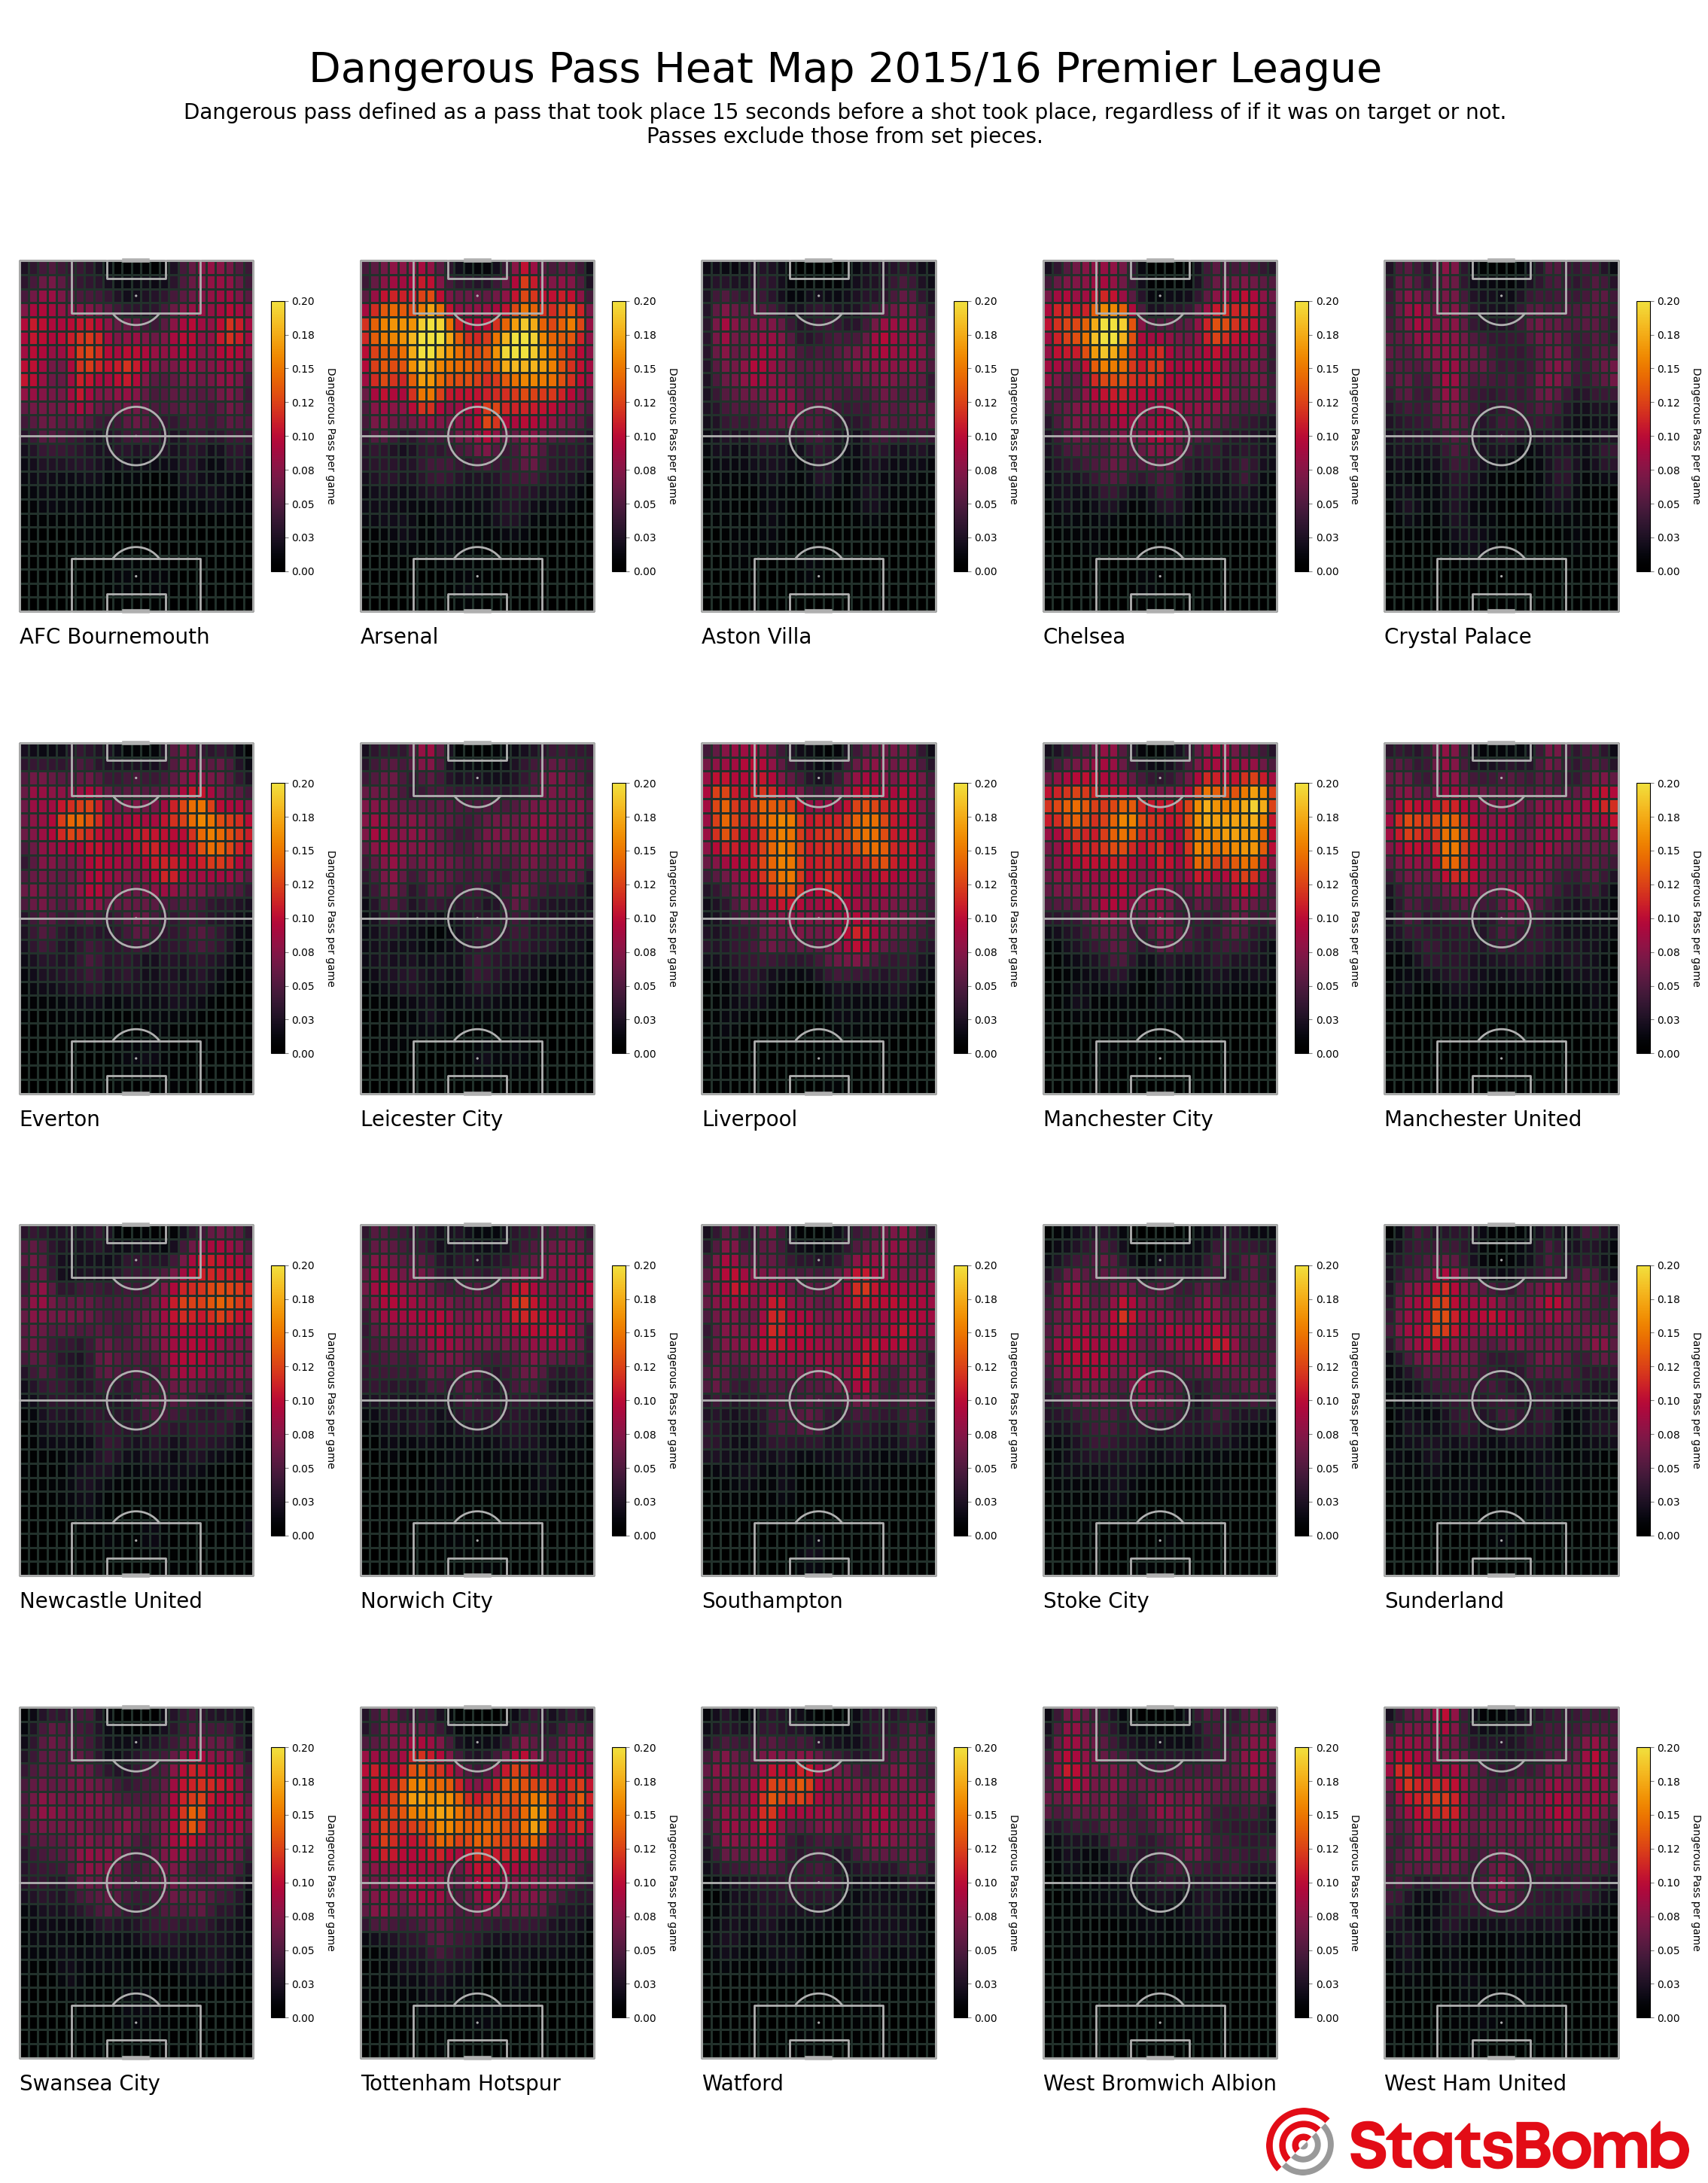

In [107]:
from matplotlib.ticker import FuncFormatter
from PIL import Image
from urllib.request import urlopen
from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen

SB_LOGO_URL = ('https://raw.githubusercontent.com/statsbomb/open-data/'
               'master/img/SB%20-%20Icon%20Lockup%20-%20Colour%20positive.png')
sb_logo = Image.open(urlopen(SB_LOGO_URL))


def format_cb_ticks(x, pos):
    return f'{x:.2f}'  # Change 2 to the desired number of decimal places

pitch = VerticalPitch(linewidth=2, line_zorder=2)
# plot the 5 * 3 grid
fig, axs = pitch.grid(nrows=4, ncols=5, figheight=30,
                    endnote_height=0.03, endnote_space=0,
                    axis=False,
                    title_height=0.08, grid_height=0.84, grid_width=0.8)
fig.set_facecolor('white')

num_teams = len(teams)
team_data = {key: value for key, value in sorted(team_data.items())}
team_names = list(team_data.keys())

for idx, ax in enumerate(axs['pitch'].flat):
    pcm = pitch.heatmap(team_data[team_names[idx]], ax=ax, cmap=cmr.ember, edgecolors='#22312b', vmin = 0, vmax = 0.20)
    ax.text(0, -9, team_names[idx], ha='left', va='center', fontsize=20 ,color='black')

    # Add a single colorbar on the side of the figure
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6,format=FuncFormatter(format_cb_ticks), pad=0.02)
    cbar.outline.set_edgecolor('black')
    cbar.ax.yaxis.set_tick_params(color='grey')
    cbar.set_label('Dangerous Pass per game', rotation=270,labelpad=20)

axs['title'].text(0.5, 0.65, 'Dangerous Pass Heat Map 2015/16 Premier League', fontsize=40, va='center', ha='center')
SUB_TEXT = ('Dangerous pass defined as a pass that took place 15 seconds before a shot took place, regardless of if it was on target or not.\n' 
            'Passes exclude those from set pieces.')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=20, va='center', ha='center')
ax_sb_logo = add_image(sb_logo, fig, left=0.701126,
                       # set the bottom and height to align with the endnote
                       bottom=axs['endnote'].get_position().y0,
                       height=axs['endnote'].get_position().height)

plt.show()

## Top chance creators

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd
from mplsoccer import VerticalPitch
from scipy.ndimage import gaussian_filter
import cmasher as cmr


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

parser = Sbopen()
df_comp = parser.competition()

df_match = parser.match(competition_id=2, season_id=27)
teams = df_match["home_team_name"].unique()

pitch = VerticalPitch(linewidth=4, line_zorder=2)


team_data = {}
teams_most_chances_player = {}


for team in teams:
    #get list of games by our team, either home or away
    match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
    #calculate number of games
    no_games = len(match_ids)
    team_chances = pd.DataFrame()
    player_chances = pd.DataFrame()
    # go through each match ID
    for idx in match_ids:
        # open the event data for this game [0]
        df = parser.event(idx)[0]
        # this is for either half of the match
        for period in [1,2]:
            # keep only chances created from pass for this team
            try:
                mask_chance = (df.team_name == team) & (df.type_name == "Pass") & (df.pass_shot_assist == True) & (df.period == period) & (df.play_pattern_name == 'Regular Play')
            except:
                break
            # keep only the columns that we want
            chance = df.loc[mask_chance, ["x", "y", "player_name"]]
            #concatenate dataframe with a previous one to keep chances from whole game
            team_chances = pd.concat([team_chances, chance], ignore_index = True)
        team_data[team] = team_chances
    # here we get all the chances created by the player who made the most chances
    player_counts = team_data[team]['player_name'].value_counts()
    most_common_player = player_counts.idxmax()
    team_dataframe = team_data[team]
    data = team_dataframe.loc[(team_dataframe.player_name == most_common_player), ['x', 'y', 'player_name']]
    player_chances = pd.concat([player_chances, data], ignore_index=True)
    teams_most_chances_player[team] = player_chances

In [45]:
print(type(teams_most_chances_player['AFC Bournemouth']['player_name']))

players = []
teams = []
for team in teams_most_chances_player.keys():
    teams.append(team)

for team in sorted(teams):
    players.append(teams_most_chances_player[team]['player_name'][0])

players[2] = 'Idrissa Gueye'
players[3] = 'Cesc Fàbregas'
players[5] = 'Romelu Lukaku'
players[7] = 'Adam Lallana'
players[9] = 'Wayne Rooney'
players[14] = "Yann M''Villa"
players[15] = 'Gylfi Sigurðsson'
players[16] = 'Christian Eriksen'

players

<class 'pandas.core.series.Series'>


['Andrew Surman',
 'Mesut Özil',
 'Idrissa Gueye',
 'Cesc Fàbregas',
 'Wilfried Zaha',
 'Romelu Lukaku',
 'Danny Drinkwater',
 'Adam Lallana',
 'Kevin De Bruyne',
 'Wayne Rooney',
 'Moussa Sissoko',
 'Jonathan Howson',
 'Dušan Tadić',
 'Marko Arnautović',
 "Yann M''Villa",
 'Gylfi Sigurðsson',
 'Christian Eriksen',
 'Troy Deeney',
 'Darren Fletcher',
 'Dimitri Payet']

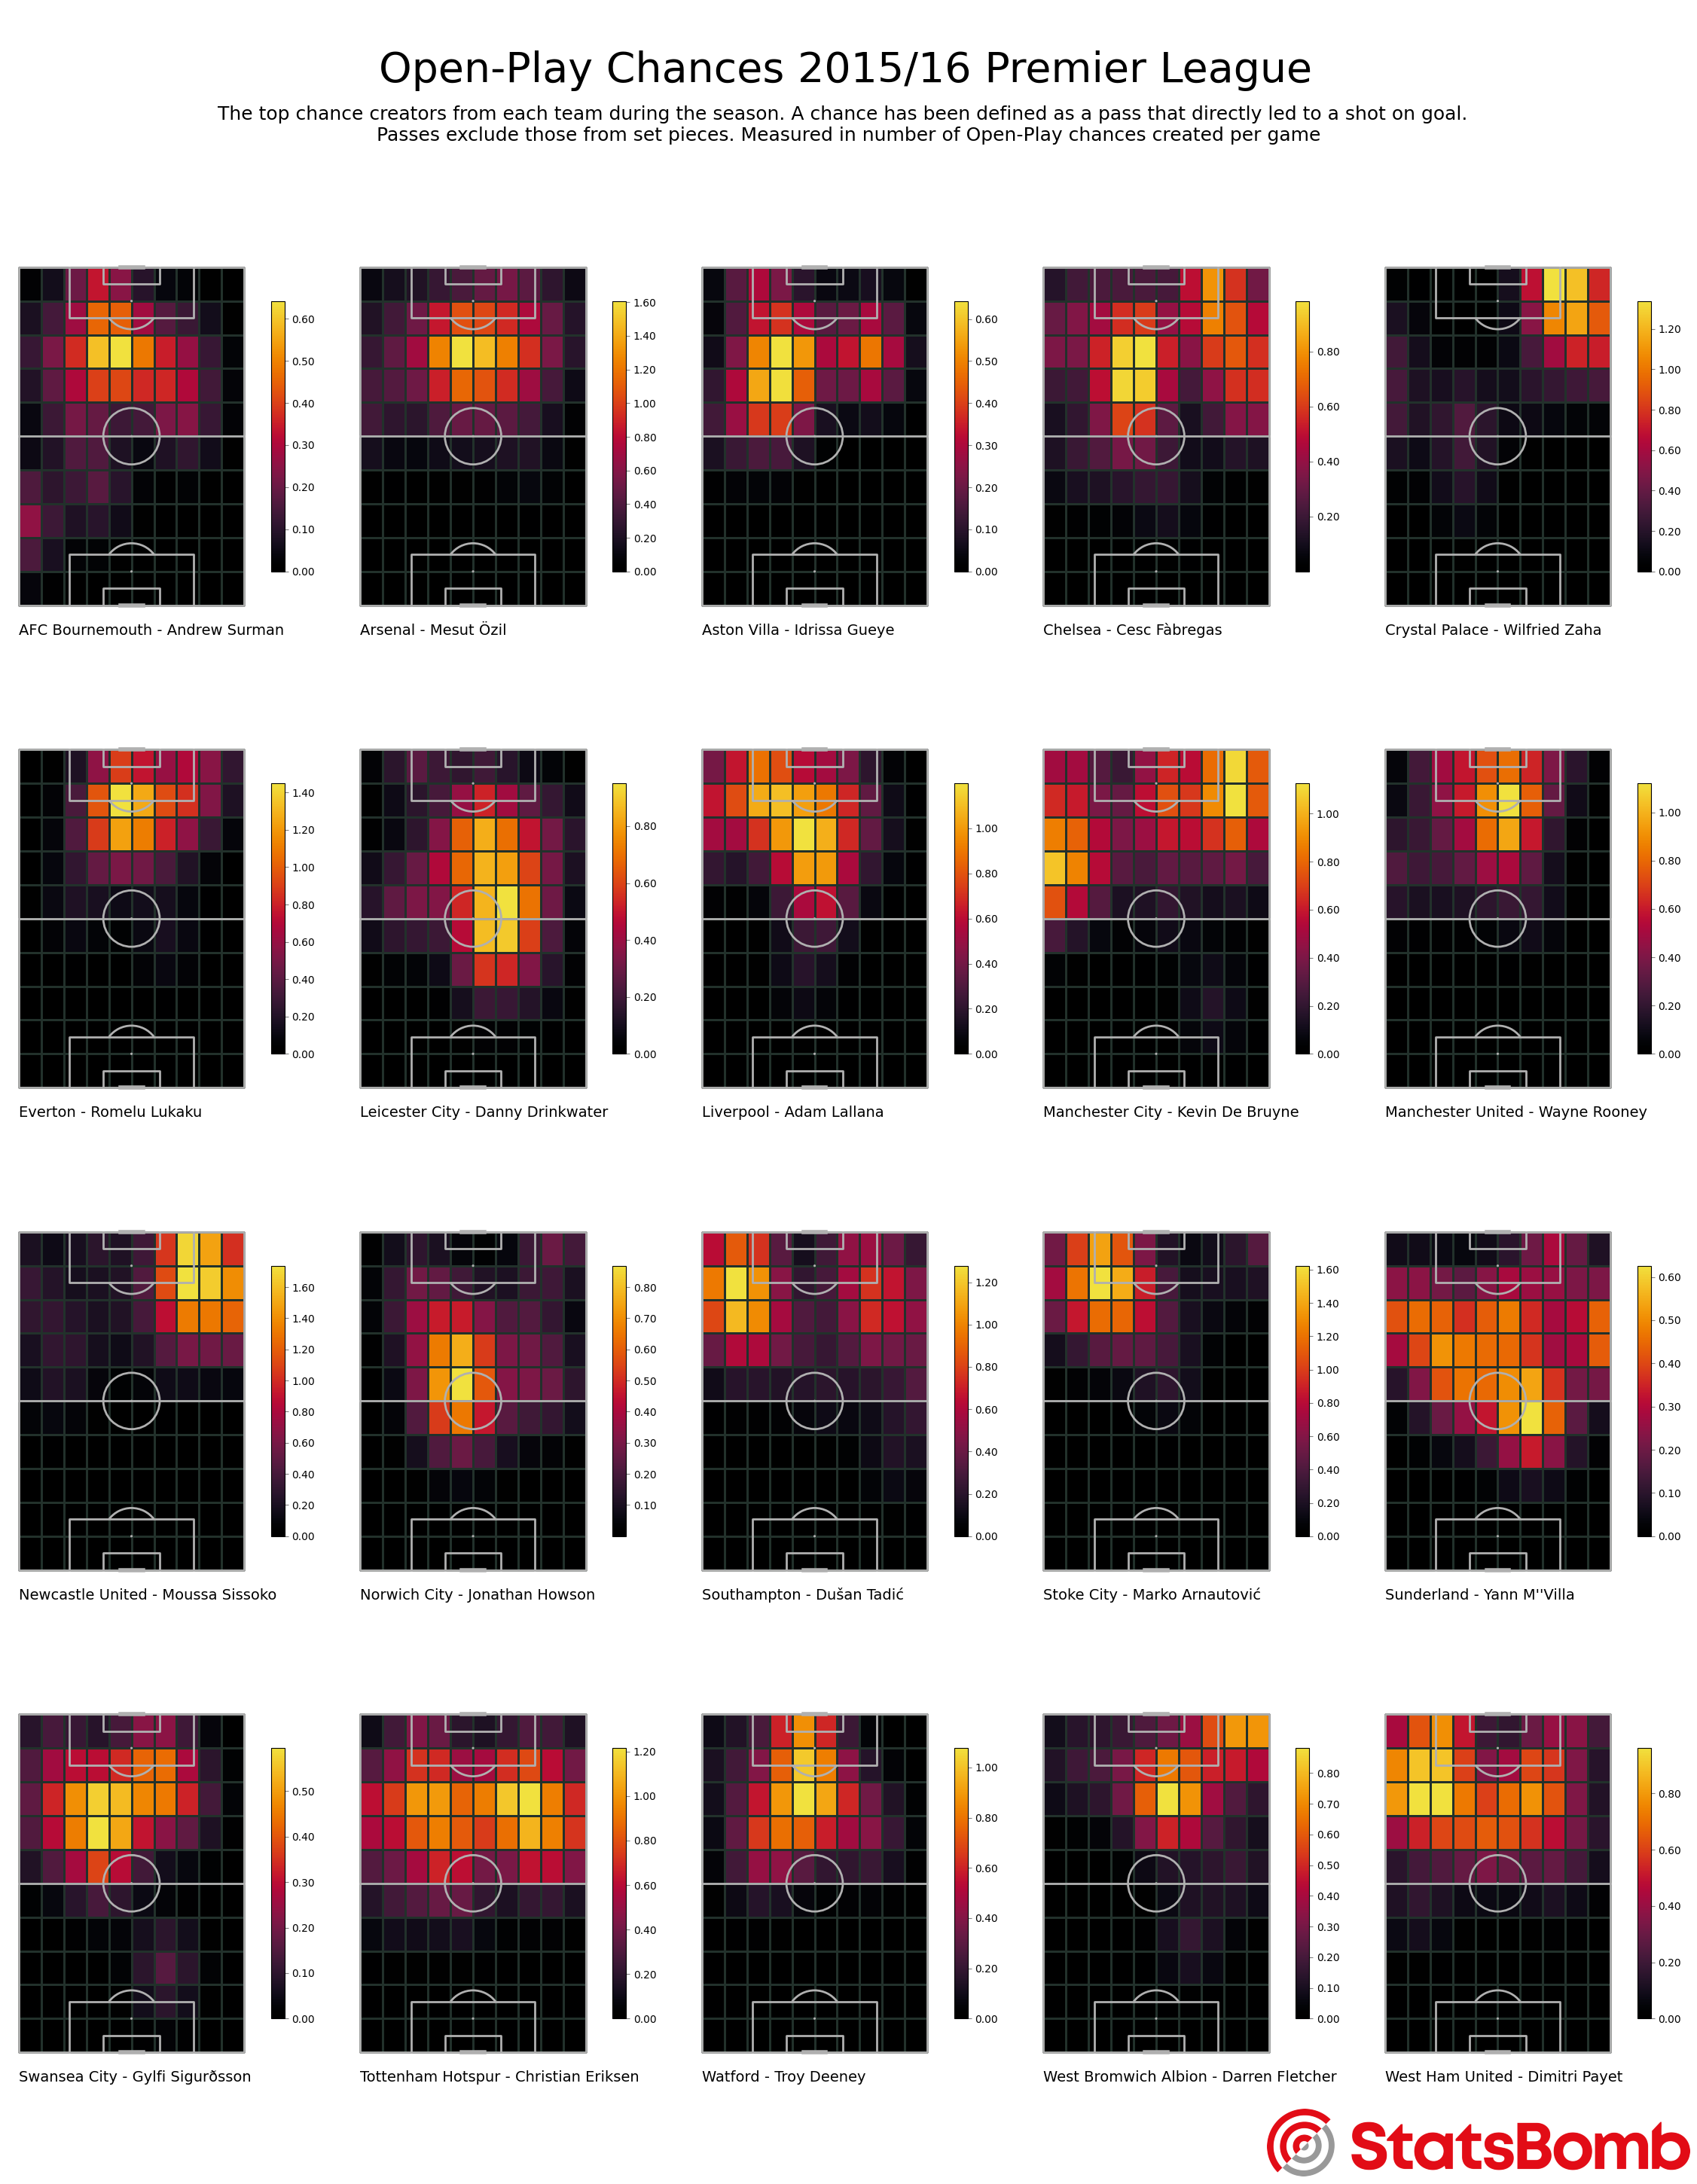

In [51]:
heat_map_data = {} 
for idx, ax in enumerate(axs['pitch'].flat):
    bin_statistic = pitch.bin_statistic(teams_most_chances_player[team_names[idx]].x, teams_most_chances_player[team_names[idx]].y, statistic='count', bins=(10, 10), normalize=False)
    bin_statistic["statistic"] = bin_statistic["statistic"]
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    # Store data for this team
    heat_map_data[team_names[idx]] = bin_statistic 

from matplotlib.ticker import FuncFormatter
from PIL import Image
from urllib.request import urlopen
from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen

SB_LOGO_URL = ('https://raw.githubusercontent.com/statsbomb/open-data/'
               'master/img/SB%20-%20Icon%20Lockup%20-%20Colour%20positive.png')
sb_logo = Image.open(urlopen(SB_LOGO_URL))


def format_cb_ticks(x, pos):
    return f'{x:.2f}'  # Change 2 to the desired number of decimal places

pitch = VerticalPitch(linewidth=2, line_zorder=2)
# plot the 5 * 3 grid
fig, axs = pitch.grid(nrows=4, ncols=5, figheight=30,
                    endnote_height=0.03, endnote_space=0,
                    axis=False,
                    title_height=0.08, grid_height=0.84, grid_width=0.8)
fig.set_facecolor('white')

num_teams = len(teams)
team_data = {key: value for key, value in sorted(team_data.items())}
team_names = list(team_data.keys())

for idx, ax in enumerate(axs['pitch'].flat):
    pcm = pitch.heatmap(heat_map_data[team_names[idx]], ax=ax, cmap=cmr.ember, edgecolors='#22312b')
    ax.text(0, -9, f'{team_names[idx]} - {players[idx]}', ha='left', va='center', fontsize=14 ,color='black') 
    # Add a single colorbar on the side of the figure
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6, format=FuncFormatter(format_cb_ticks))
    cbar.outline.set_edgecolor('black')
    cbar.ax.yaxis.set_tick_params(color='grey')

axs['title'].text(0.5, 0.65, 'Open-Play Chances 2015/16 Premier League', fontsize=40, va='center', ha='center')
SUB_TEXT = ('The top chance creators from each team during the season. A chance has been defined as a pass that directly led to a shot on goal. \n Passes exclude those from set pieces. Measured in number of Open-Play chances created per game')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=18, va='center', ha='center')
ax_sb_logo = add_image(sb_logo, fig, left=0.701126,
                       # set the bottom and height to align with the endnote
                       bottom=axs['endnote'].get_position().y0,
                       height=axs['endnote'].get_position().height)

plt.show()

## Top assisters pass map

In [54]:
import pickle 
        
with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

top_5_assist_data = loaded_dict
loaded_dict

# Define the desired order of keys
desired_order = ['Mesut Özil', 'Christian Dannemann Eriksen',  'Riyad Mahrez', 'Dimitri Payet', 'Dušan Tadić']

# Create a new dictionary with keys reordered based on the desired order
reordered_dict = {key: loaded_dict[key] for key in desired_order if key in loaded_dict}

top_5_assist_data = reordered_dict
player_names = desired_order


In [111]:
top_5_assist_data['Dimitri Payet']['chances']

,x,y,end_x,end_y,player_name
0,48.7,14.4,57.0,46.3,Dimitri Payet
1,88.4,30.0,98.7,24.1,Dimitri Payet
2,120.0,80.0,111.9,41.3,Dimitri Payet
3,91.9,8.3,87.5,32.7,Dimitri Payet
4,83.5,64.6,115.4,34.2,Dimitri Payet
5,99.0,2.5,107.5,33.5,Dimitri Payet
6,94.9,67.3,107.5,42.7,Dimitri Payet
7,54.8,40.6,77.1,1.9,Dimitri Payet
8,76.7,52.6,105.7,51.7,Dimitri Payet
9,75.8,32.3,107.3,42.7,Dimitri Payet


Text(0.5, 0.35, 'All passes made by the top 5 players in the assist leaderboard for the season. Passes which led to a shot and passes which created a goal are outlined.\nSet pieces and failed passes are included.')

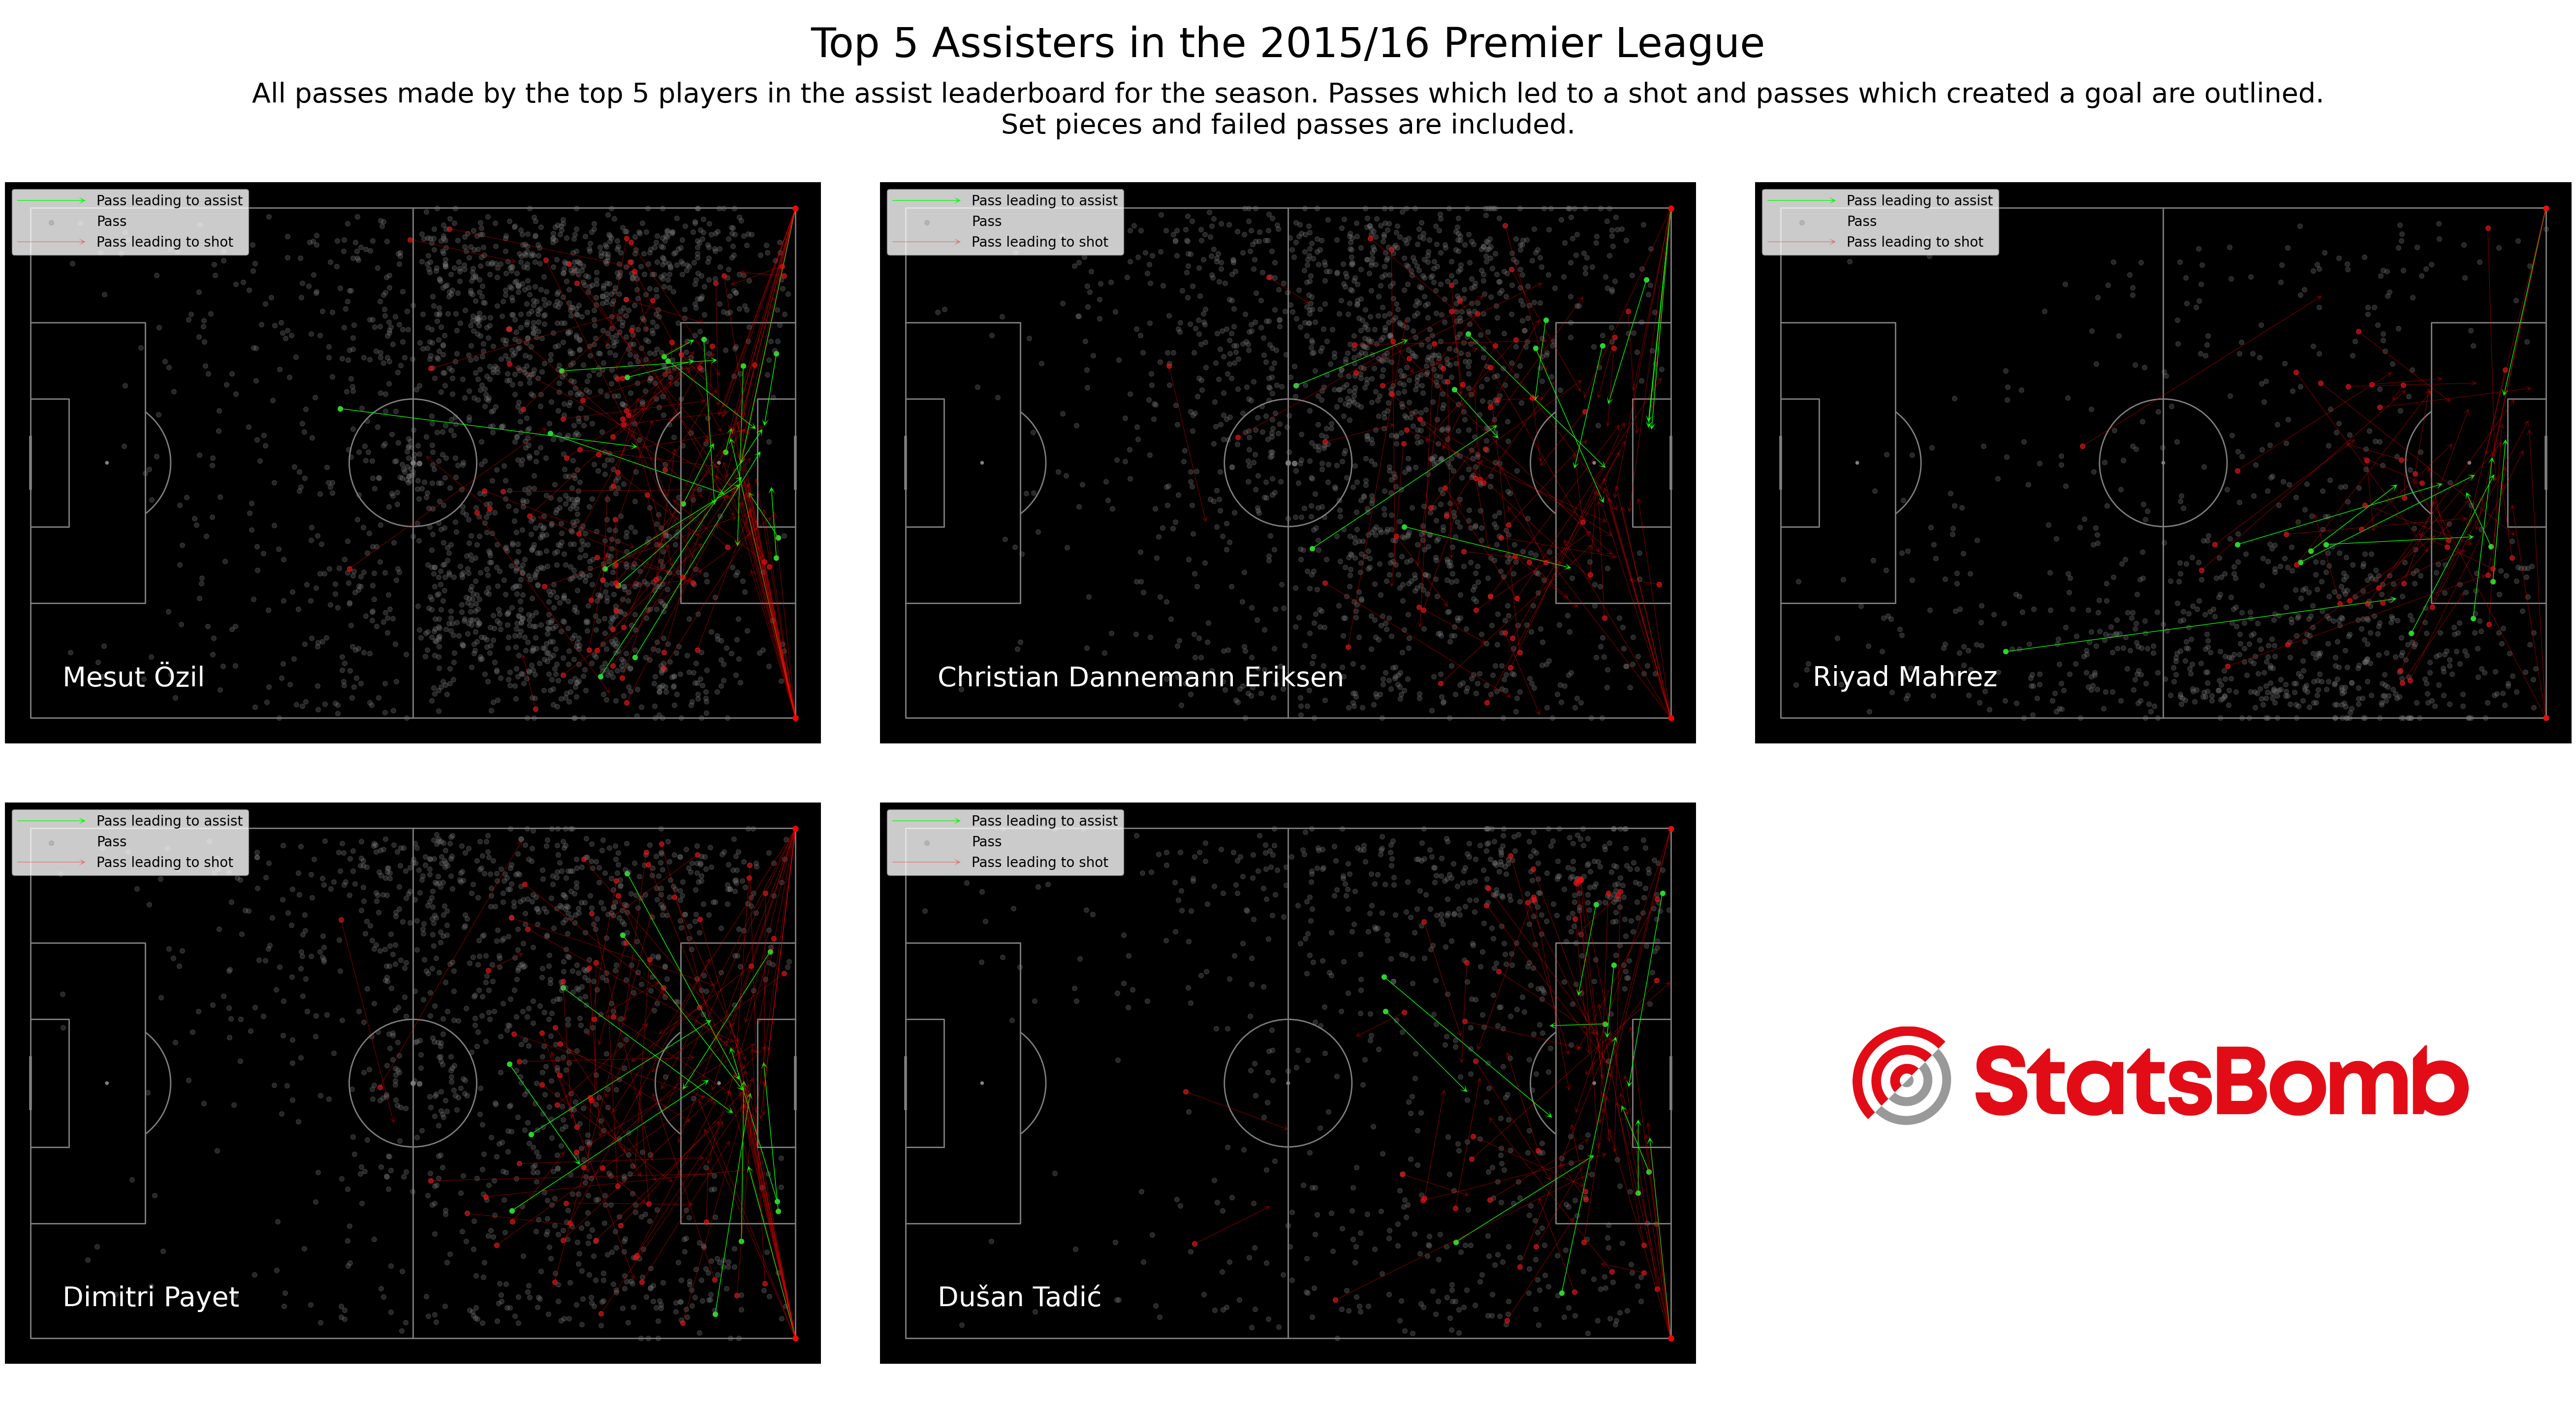

In [55]:
from mplsoccer import VerticalPitch
from matplotlib.ticker import FuncFormatter
from PIL import Image
from urllib.request import urlopen
from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen

SB_LOGO_URL = ('https://raw.githubusercontent.com/statsbomb/open-data/'
               'master/img/SB%20-%20Icon%20Lockup%20-%20Colour%20positive.png')
sb_logo = Image.open(urlopen(SB_LOGO_URL))
pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='grey')
# plot the 5 * 3 grid
fig, axs = pitch.grid(nrows=2, ncols=3, figheight=30,
                    endnote_height=0.02, endnote_space=0.01,
                    axis=False,
                    title_height=0.11, grid_height=0.80, grid_width=0.5)
fig.set_facecolor('white')


for idx, ax in enumerate(axs['pitch'].flat):
    if idx < len(axs['pitch'].flat) - 1:
        pitch.scatter(top_5_assist_data[player_names[idx]]['assists'].x, top_5_assist_data[player_names[idx]]['assists'].y, alpha = 1, s = 50, color = "lime", ax=ax)
        pitch.arrows(top_5_assist_data[player_names[idx]]['assists'].x, top_5_assist_data[player_names[idx]]['assists'].y, top_5_assist_data[player_names[idx]]['assists'].end_x, top_5_assist_data[player_names[idx]]['assists'].end_y, width = 1, headwidth = 10, headlength = 10, color='lime', ax=ax, label='Pass leading to assist')
        pitch.scatter(top_5_assist_data[player_names[idx]]['passes'].x, top_5_assist_data[player_names[idx]]['passes'].y, alpha = 0.3, s = 50, color = "grey", ax=ax, label='Pass')
        pitch.scatter(top_5_assist_data[player_names[idx]]['chances'].x, top_5_assist_data[player_names[idx]]['chances'].y, alpha = 0.5, s = 50, color = "red", ax=ax)
        pitch.arrows(top_5_assist_data[player_names[idx]]['chances'].x, top_5_assist_data[player_names[idx]]['chances'].y, top_5_assist_data[player_names[idx]]['chances'].end_x, top_5_assist_data[player_names[idx]]['chances'].end_y, width = 1, alpha=0.4, headwidth = 10, headlength = 10, color='red', ax=ax, label='Pass leading to shot')
        ax.legend(facecolor='white', handlelength=5, edgecolor='grey', fontsize=20, loc='upper left')
        ax.text(5, 75, f'{player_names[idx]}', color='white', fontsize=40,)

    else:
        # Do something different with the last axes
        ax.set_facecolor('white')
        ax.clear()    
    
        ax_sb_logo = add_image(sb_logo, fig, left=0.61, bottom=0.15, width=0.12, height=0.2)

axs['title'].text(0.5, 0.75, 'Top 5 Assisters in the 2015/16 Premier League', fontsize=60, va='center', ha='center')
SUB_TEXT = ('All passes made by the top 5 players in the assist leaderboard for the season. Passes which led to a shot and passes which created a goal are outlined.\n'
            'Set pieces and failed passes are included.')
axs['title'].text(0.5, 0.35, SUB_TEXT, fontsize=40, va='center', ha='center')